In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
import matplotlib.cm as cm
import matplotlib.colors as mcolors

import xtrack as xt
import xpart as xp
import xobjects as xo
import xcoll as xc
import scipy.constants as sc

In [3]:
cavity_names[0]

'actcse.31632'

In [5]:
line = xt.Line.from_json('../../injection_lines/sps_q20_inj.json')
tt = line.get_table()
tw = line.twiss()
env = line.env
cavity_elements, cavity_names = line.get_elements_of_type(xt.Cavity)

for name in cavity_names:
    line[name].frequency = 200e6
    line[name].lag = 180
    line[name].voltage = 0.0
line['actcse.31632'].voltage = 3e6

tte = env.elements.get_table()
mask_rbends = tte.element_type == 'RBend'
mask_quads = tte.element_type == 'Quadrupole'
mask_sextupoles = tte.element_type == 'Sextupole'

mba = tte.rows[mask_rbends].rows['mba.*'].name
mbb = tte.rows[mask_rbends].rows['mbb.*'].name
qf = tte.rows[mask_quads].rows['qf.*'].name
qd = tte.rows[mask_quads].rows['qd.*'].name
lsf = tte.rows[mask_sextupoles].rows['lsf.*'].name
lsd = tte.rows[mask_sextupoles].rows['lsd.*'].name

on_sextupole = 1
on_octupole = 1
on_decapole = 1
on_dodecapole = 1

for nn in mba:
    env[nn].knl = np.array([0., 0.,
                            on_sextupole * 2.12e-3,
                            0.,
                            on_decapole * -5.74,
                            on_dodecapole * 0.])

for nn in mbb:
    env[nn].knl = np.array([0., 0.,
                            on_sextupole * -3.19e-3,
                            0.,
                            on_decapole * -5.10,
                            on_dodecapole * 0.])

for nn in qf:
    env[nn].knl = np.array([0., 0.,
                            0.,
                            on_octupole * 0.75e-1,
                            0.,
                            on_dodecapole * -0.87e3])

for nn in qd:
    env[nn].knl = np.array([0., 0.,
                            0.,
                            on_octupole * -2.03e-1,
                            0.,
                            on_dodecapole * 2.04e3])


env.vars['qph_setvalue'] = 0.5
env.vars['qpv_setvalue'] = 0.5
qx = 20.13
qy = 20.18
opt = line.match(
    method='6d', # <- passed to twiss
    vary=[
        xt.VaryList(['kqf0', 'kqd0'], step=1e-8, tag='quad'),
        xt.VaryList(['qph_setvalue', 'qpv_setvalue'], step=1e-4, tag='sext'),
    ],
    targets = [
        xt.TargetSet(qx=qx, qy=qy, tol=1e-6, tag='tune'),
        xt.TargetSet(dqx=0.5*qx, dqy=0.5*qy, tol=1e-2, tag='chrom'),
    ])

Loading line from dict:   0%|          | 0/4037 [00:00<?, ?it/s]

Done loading line from dict.           
                                             
Optimize - start penalty: 13.73                             
Matching: model call n. 7 penalty = 2.6216e-03              
Optimize - end penalty:  0.00262155                            


In [6]:
delta_vals = []
mon_res = []
mon_res_norm = []

r = np.linspace(0, 40, 100)
phi = np.linspace(0, 2*np.pi, 10, endpoint=False)
r, phi = np.meshgrid(r, phi)
x_norm = r.flatten() * np.cos(phi.flatten())
px_norm = r.flatten() * np.sin(phi.flatten())
line.discard_tracker()
line.build_tracker(_context=xo.ContextCpu(omp_num_threads=12))
for delta_val in [0.0, 5e-4, 1e-3, 2e-3, 3e-3, 4e-3]:
    tw0 = line.twiss4d(delta0=delta_val)
    p = line.build_particles(method='4d',
        x_norm=x_norm, px_norm=px_norm, nemitt_x=2e-6, nemitt_y=2e-6, delta=delta_val)

    line.track(p, num_turns=300, turn_by_turn_monitor=True, with_progress=1)

    mon = line.record_last_track
    mon_norm= tw0.get_normalized_coordinates(mon, nemitt_x=2e-6, nemitt_y=2e-6)

    delta_vals.append(delta_val)
    mon_res.append(mon)
    mon_res_norm.append(mon_norm)

Compiling ContextCpu kernels...


ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored
ld: warning: duplicate -rpath '/Users/lisepauwels/miniforge3/envs/xcoll/lib' ignored


Done compiling ContextCpu kernels.


Tracking:   0%|          | 0/300 [00:00<?, ?it/s]

Tracking:   0%|          | 0/300 [00:00<?, ?it/s]

/Users/lisepauwels/Xsuite/xtrack/xtrack/twiss.py:4005: RuntimeWarning: invalid value encountered in divide
  pzeta = ctx2np(particles.ptau)[mask_at_ele]/ctx2np(particles.beta0)[mask_at_ele],


Tracking:   0%|          | 0/300 [00:00<?, ?it/s]

Tracking:   0%|          | 0/300 [00:00<?, ?it/s]

Tracking:   0%|          | 0/300 [00:00<?, ?it/s]

Tracking:   0%|          | 0/300 [00:00<?, ?it/s]

In [8]:
import matplotlib as mpl

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


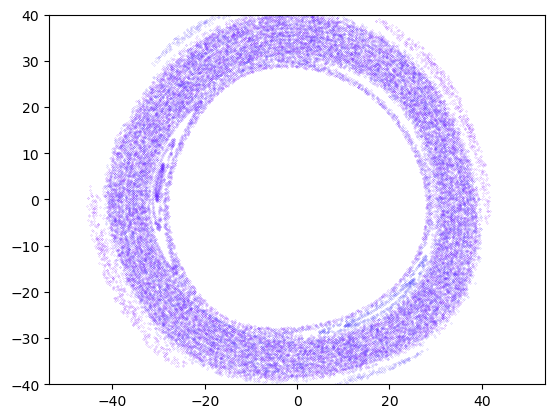

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


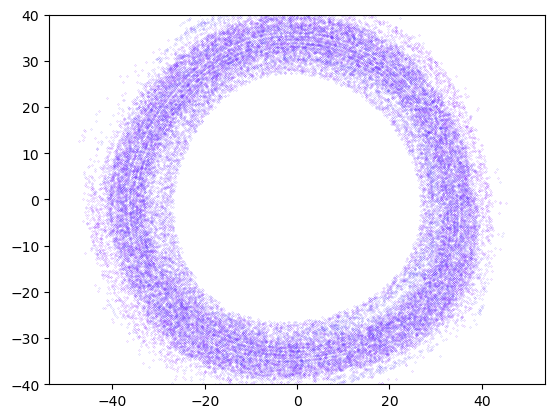

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


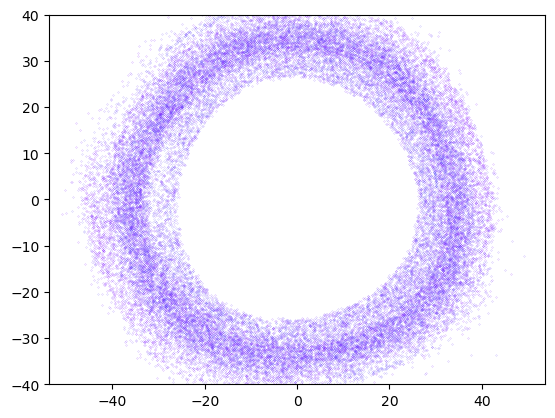

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


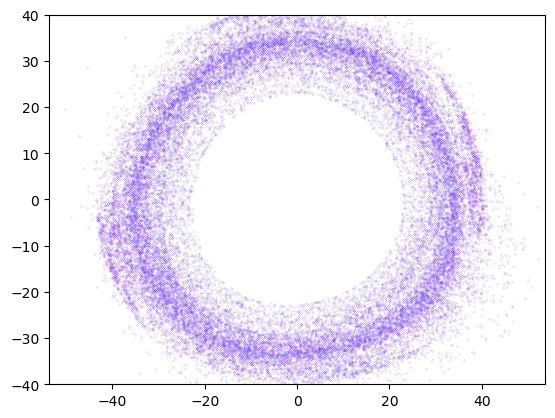

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


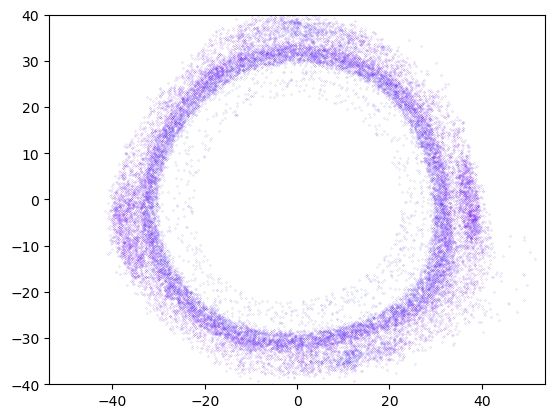

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


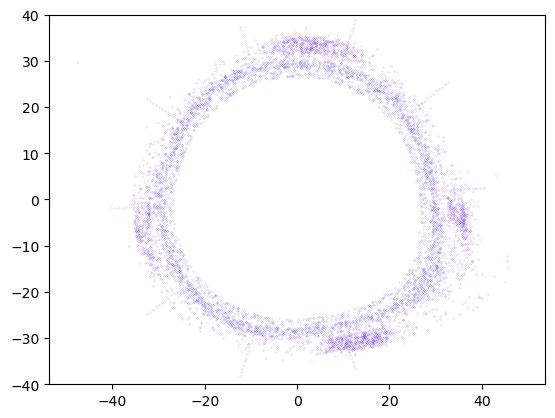

In [11]:
cmap = mpl.colormaps['rainbow']
colors = cmap(np.linspace(0, 1, 100))

for mon_norm in mon_res_norm:
    plt.figure(4)
    for i in range(10):
        plt.plot(mon_norm.x_norm.T[:, i*100+75:(i+1)*100:2], mon_norm.px_norm.T[:, i*100+75:(i+1)*100:2], '.', markersize=0.2, color=colors[i])
    plt.axis('equal')
    plt.xlim((-40, 40))
    plt.ylim((-40, 40))
    plt.show()